<img src="light-bulb.png" alt="Flowers in Chania" style="float:left;width:100px;height:100px;">
<center><h1 style="color:#B40404;">Electric Power Generation prediction in Canada</h1></center>

<h5 style="color:#585858;">Author: Vannia Hnatiuk</h5>
<h5 style="color:#585858;">Date: April 4<sup>th</sup>, 2022</h5>

[1. Introduction: Facebook Prophet](#one)<br>
    [1.2 Reading the Data](#one-two)<br>
[2. Modeling](#two)<br>
[3. Evaluation](#three)<br>
[4. Conclusions](#four)<br>
[5. References](#five)<br>

<h2><a style="color:#4267B2;font-weight:bold" id='one'>Facebook Prophet</a></h2>

<p>Facebook prophet is an open source  software developed by Facebook's Core Data Science team. This model also use a decomposition of the time series with three main components and the error term:</p></br>
<li>trend</li>
<li>seasonality</li>
<li>holidays</li>

$$y(t) = g(t) + s(t) + h(t) +  \epsilon_{t}$$


Where the error term that will have the parametric assumption of being normally distributed

In [1]:
#Importin the libraries necessary for the analysis

import numpy as np
import pandas as pd

# plotting libraries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

#Facebook Prophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot

#new pandas index
from pandas import Int64Index as NumericIndex

/var/folders/rf/tbzlwmhn4t3_np15yjldzz200000gn/T/ipykernel_41731/3239882146.py:23: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#Setting a prefer template for diagnostic plots
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')


<h3 style="color:#4267B2" id='one-two'>Reading the data</h3>

This dataset was extracted from the <a style="color:#F08080;font-size:115%;" href='01_EDA.ipynb'>EDA Notebook</a> which has the required features: the dates and the dependant variable. The time frame covers from January 1950' to December 2007'. The variable of interest is <span style="color:#4267B2;font-weight:bold"> VALUE</span> which quantifies the electric power generated in millions of Megawatts-Hour.

In [3]:
df=pd.read_csv('data/can_50_08.csv', parse_dates=['REF_DATE'])

A quick inspection of the working dataframe.

In [4]:
df.head()

,REF_DATE,VALUE
0,1950-01-01,4081000.0
1,1950-02-01,3780000.0
2,1950-03-01,4186000.0
3,1950-04-01,4070000.0
4,1950-05-01,4425000.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   REF_DATE  696 non-null    datetime64[ns]
 1   VALUE     696 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.0 KB


This dataframe has 696 rows and two columns in datetime format for dates and float64 in 'VALUE'. Provided that, Facebook prophet model requires a dataframe with specific names for the variables:
<ul>
<li><span style="color:#4267B2;font-weight:bold">ds:</span> datetime column </li>
<li><span style="color:#4267B2;font-weight:bold">y:</span> feature to predict: Electric Power in Millions of Megawatts</li>
</ul>

In [6]:
#Renaming the columns 
df.rename(columns={"REF_DATE": "ds", "VALUE": "y"}, inplace=True)

Selecting train and test datasets

In [7]:
#Training dataset for time period before December 1st of 2003
train=df[df['ds'] <= "1999-12-01"].copy()

#test dataset for time period after December 1st of 2003
test=df[df['ds'] > "1999-12-01"].copy()

<center><h2 style="color:#4267B2" id='two'>Modeling</h2></center>

Based on the EDA analysis, the system shows stronger multiplicative seasonality, which means that the variance (amplitude) of the wave gets larger from the crest to the botom. Provided that, prophet was set on <span style="color:#4267B2;font-weight:bold">multiplicative</span> seasonality mode.<br>
One great feature of Prophet, is that `holidays` can be considered in the model. Fortunately, there is a built-in collection of holidays for designated countries where Canada could be added.

In [8]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=6)
model.add_country_holidays(country_name='CA')
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.16456


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2040.82    0.00251561       214.348           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2048.71    0.00831872       223.617           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       2051.86   0.000684686       348.021   2.593e-06       0.001      388  LS failed, Hessian reset 
     299       2052.27    0.00118238       190.248           1           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2052.88   2.65953e-06       60.1552           1           1      538   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     453       2053.18   3.72036e-05       106.825   3.808e-07       0.001      6

Building a dataframe that will store the values for the prediction.

In [9]:
future = model.make_future_dataframe(periods=len(test), freq="MS", include_history=True)
future.head()

,ds
0,1950-01-01
1,1950-02-01
2,1950-03-01
3,1950-04-01
4,1950-05-01


Forecast dataframe with the most relevant features <span style="color:#4267B2"> "yhat", "yhat_lower"</span> and <span style="color:#4267B2"> "yhata_upper" </span>

In [10]:
# This dataframe must also requires a `ds` column
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
691,2007-08-01,4.886471e+07,4.723098e+07,5.053961e+07
692,2007-09-01,4.643459e+07,4.493328e+07,4.809130e+07
693,2007-10-01,5.069709e+07,4.908281e+07,5.249168e+07
694,2007-11-01,5.388715e+07,5.230001e+07,5.568497e+07
695,2007-12-01,5.969856e+07,5.802175e+07,6.147130e+07


<center><h2 style="color:#4267B2" id='three'>Evaluation</h2></center>

<h4>Anatomy of a Prediction</h4>

Prophet has its own method to plot in order to compare the orginal data with the prediction as seen below:

In [11]:
fig = plot_plotly(model, forecast, xlabel='Decades', ylabel='Megawatt-Hour') # returns a plotly Figure object
fig.update_layout(plot_bgcolor='#F0ECEC', title_text='Original Data and Prediction Comparison', 
                    showlegend=True,title_x=0.5)
fig.show()

The original data is represented by the scattered black points, whereas the blue line is the actual prediction. The prediction highlights peaks, plateaus and dips based on the original data.

<h4>Trend Changepoints</h4>

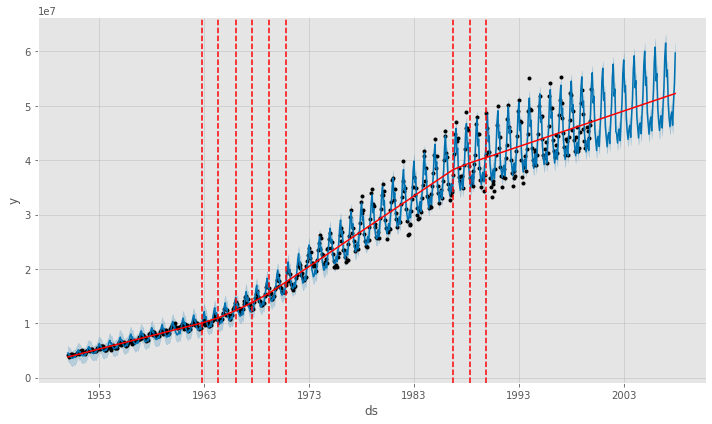

In [12]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

Another nice Prophet's utility is the automatic detection of trend change points; as a result, it makes a respective `adjustment` of the prediction. In the upper plot, Prophet found six shifts in from 1961 to 1970, later two adjustments in the mids eighties while a final change in 93. 

<h3>Prediction Evaluation</h3>

For a better appreciation of Prophet's forecast, it was tailored a line plot where the original data can be compared to the prediction. For this reason, it was created a dataframe where can merge the original data and the forecast with focus on <span style="color:#4267B2;font-weight:bold"> y </span> and <span style="color:#4267B2;font-weight:bold"> yhat</span>.

In [13]:
#Forecast subset saved to my_forecast dataframe
my_forecast=forecast[['ds','yhat_lower','yhat_upper','yhat']]

In [14]:
my_forecast

,ds,yhat_lower,yhat_upper,yhat
0,1950-01-01,3.118739e+06,5.883682e+06,4.553539e+06
1,1950-02-01,2.819227e+06,5.504247e+06,4.127014e+06
2,1950-03-01,2.914833e+06,5.564783e+06,4.268018e+06
3,1950-04-01,2.405965e+06,5.145582e+06,3.812098e+06
4,1950-05-01,2.309593e+06,5.005109e+06,3.669332e+06
...,...,...,...,...
691,2007-08-01,4.723098e+07,5.053961e+07,4.886471e+07
692,2007-09-01,4.493328e+07,4.809130e+07,4.643459e+07
693,2007-10-01,4.908281e+07,5.249168e+07,5.069709e+07
694,2007-11-01,5.230001e+07,5.568497e+07,5.388715e+07


Joining test subset with forecast subset.

In [15]:
df_merge = pd.merge(test, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2000-01-01,5.472361e+07,5.741237e+07,5.607960e+07,57271638.0
1,2000-02-01,4.922299e+07,5.187504e+07,5.052343e+07,52266866.0
2,2000-03-01,5.036624e+07,5.312764e+07,5.175679e+07,50535074.0
3,2000-04-01,4.415283e+07,4.672986e+07,4.545928e+07,45641566.0
4,2000-05-01,4.247412e+07,4.510917e+07,4.374562e+07,45489843.0


In [16]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], line_color='#515A5A',
                                opacity=0.7,mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'],
                                mode='lines',opacity=0.7, name="Test"))
fig.add_trace(go.Scatter(x=my_forecast['ds'], y=my_forecast['yhat'], mode='lines', 
                            line_color='#4267B2', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Millions of Megawatts of Power Generated ", 
    xaxis_title="Date",
    title="Original Data vs Prediction",
    title_x=0.5,
    plot_bgcolor='#F0ECEC'
)
fig.show()

 The plateaus in March are due to the transition caused by the daylight saving time. While the small peaks in summer months of July and August are due to the utilization of air conditioning. The final prediction forecast a supply of 61.24 Millions of Megawatt-hour.

<h4>Prediction Scores</h4>

In order to know the precision of the prediction, it will be evaluated under the metrics <span style="color:#4267B2;font-weight:bold">mean absolute error</span> and <span style="color:#4267B2;font-weight:bold">mean absolute percentage error </span>. Through these measurements, this model can be compared with it's counterpart: SARIMAX from statsmodel. 

In [17]:
trained_forecast=forecast[forecast['ds']<='1999-12-01']

In [18]:
test_forecast=forecast[forecast['ds']>= '2000-01-01']

In [19]:
# calculate MAE  and MAPE in training data
y_true_train = train['y']
y_pred_train = trained_forecast['yhat']
train_mae_01 = mean_absolute_error(y_true_train, y_pred_train)
train_mape_01 = mean_absolute_percentage_error(y_true_train, y_pred_train)*100

<h4>Scores in Training data</h4>

In [20]:
print(f'the Mean Absolute Error in training data is {train_mae_01:,.2f}')

the Mean Absolute Error in training data is 784,938.33


In [21]:
print(f'the Mean Absolute Percentage Error in training data is {train_mape_01:.3f}')

the Mean Absolute Percentage Error in training data is 4.155


<h4>Scores in Testing data</h4>

In [22]:
y_true_test = test['y']
y_pred_test = test_forecast['yhat']
test_mae_01 = mean_absolute_error(y_true_test, y_pred_test)
test_mape_01 = mean_absolute_percentage_error(y_true_test, y_pred_test)*100

In [23]:
print(f'the Mean Absolute Error in test data is {test_mae_01:,.2f}')

the Mean Absolute Error in test data is 1,998,462.67


In [24]:
print(f'the Mean Absolute Percentage Error in test data is {test_mape_01:.3f}')

the Mean Absolute Percentage Error in test data is 4.181


The prediction was <b>1.48 million</b> of MWH apart from the real value. Equally important the Mean Absolute Percentage Error <b>is 3.10 %</b>. This model had a better prediction than ARIMA on a seasonal difference but lesser precise than ARIMA seasonal. 

In [25]:
fig = go.Figure()

#yupper
fig.add_trace(go.Scatter(x=my_forecast['ds'], y=my_forecast['yhat_upper'], 
                            opacity=0.4,line_color='#4267B2', mode='markers', name="y_upper"))

#yhat                            
fig.add_trace(go.Scatter(x=my_forecast['ds'], y=my_forecast['yhat'],
                            line_color='#515A5A', mode='lines', name="yhat"))  
#ylower
fig.add_trace(go.Scatter(x=my_forecast['ds'], y=my_forecast['yhat_lower'], mode='markers', 
                            opacity=0.4 ,line_color='#4267B2', name="y_lower"))
fig.update_xaxes(rangeslider_visible=True, constraintoward='middle')
fig.update_layout(
    yaxis_title="Megawatts of Power Generated ", 
    xaxis_title="Date",
    title="Forecast Dissection",
    title_x=0.5,
    plot_bgcolor='#F0ECEC',
    margin_pad=0
)
fig.show()

<span style="color:#4267B2;font-weight:bold"> 'yhat'</span> represents the power generation prediction from prophet's while <span style="color:#4267B2;font-weight:bold"> 'y_upper'</span> is the maximum range that 'yhat' can reach within 95% of the confidence interval while  <span style="color:#4267B2;font-weight:bold"> 'y_lower'</span> is the lowest value that the prediction can stepdown inside the 95% confidence interval as well. 

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



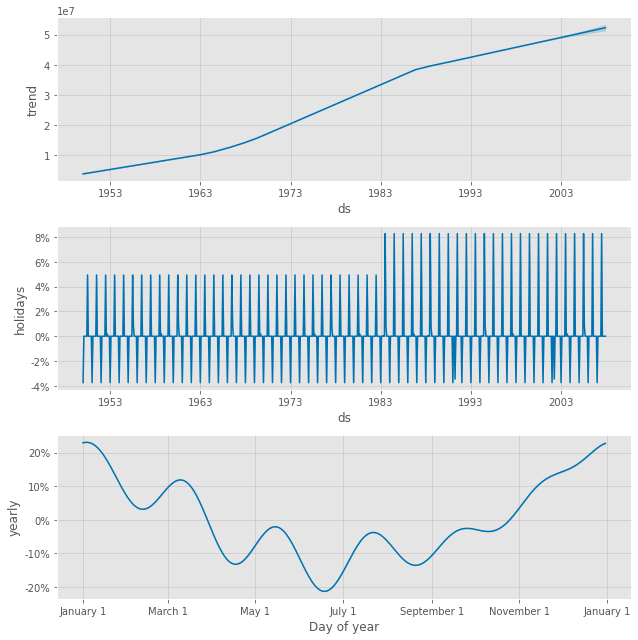

In [26]:
fig = model.plot_components(forecast)

Prophet has a method to plot the components of the time series:
<ul>
    <li>The Power generation has been increasing throughout the years</li>
    <li>About Holidays Canada Day has boosted the energy production. On the contrary, the power generation slows down on New Year's Eve.</li> 
    <li>The yearly seasonality exhibits a bumpy decrease from January to summer months. While the peaks observed in May and July are caused to the use of air conditioning systems. From autumn to the winter  the energy generation starts to increase.</li>
<ul>

<center><h2 style="color:#4267B2" id='four'>Conclusions</h2><br></center>

Facebook Prophet did the best prediction relative to ARIMA models. Provided that, it could make a robust prediction for periods ahead of 11 months. Equally important, Prophet is an advanced time series forecast model because the processing time is fast, it is accurate and it doesn't require data preprocessing as other models. For instance, it is flexible for parameter customization such the holidays and trend changepoints for domain experts. Above all, Prophet is easy to run, any data beginner can run it with little subject knowledge. <br>
The bottom line is that accurate and fast predictions can be made through this model.

<center><h2 style="color:#4267B2" id='five'>References</h2></center>

<a href='https://facebook.github.io/prophet/'>https://facebook.github.io/prophet/ </href>

<a href='https://jadsmkbdatalab.nl/forecasting-with-facebook-prophet-models-an-intro/'>https://jadsmkbdatalab.nl/forecasting-with-facebook-prophet-models-an-intro/ </href>

<a href='https://pythondata.com/forecasting-time-series-data-with-prophet-part-1/'>https://pythondata.com/forecasting-time-series-data-with-prophet-part-1/ </href>
